In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from pandas.plotting import autocorrelation_plot
import statsmodels.tsa.stattools as sts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import scipy.stats
import pylab

from utils import *

In [35]:
df = pd.read_parquet("Sales_Data_v2.parquet")

In [36]:
df["TotalQty"] = df["PaidQty"] + df["FreeQty"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8931111 entries, 0 to 8931110
Data columns (total 19 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Date               datetime64[ns]
 1   LocationId         int64         
 2   MainDistributorId  int64         
 3   DistributorId      int64         
 4   PackageId          int64         
 5   ProductId          int64         
 6   City               object        
 7   District           object        
 8   BrickId            int64         
 9   PaidQty            int64         
 10  FreeQty            int64         
 11  isPromoted         int64         
 12  Discount           float64       
 13  BeginDate          datetime64[ns]
 14  EndDate            datetime64[ns]
 15  Promo              object        
 16  DStep              float64       
 17  WeekStartDate      datetime64[ns]
 18  TotalQty           int64         
dtypes: datetime64[ns](4), float64(2), int64(10), object(3)
memory u

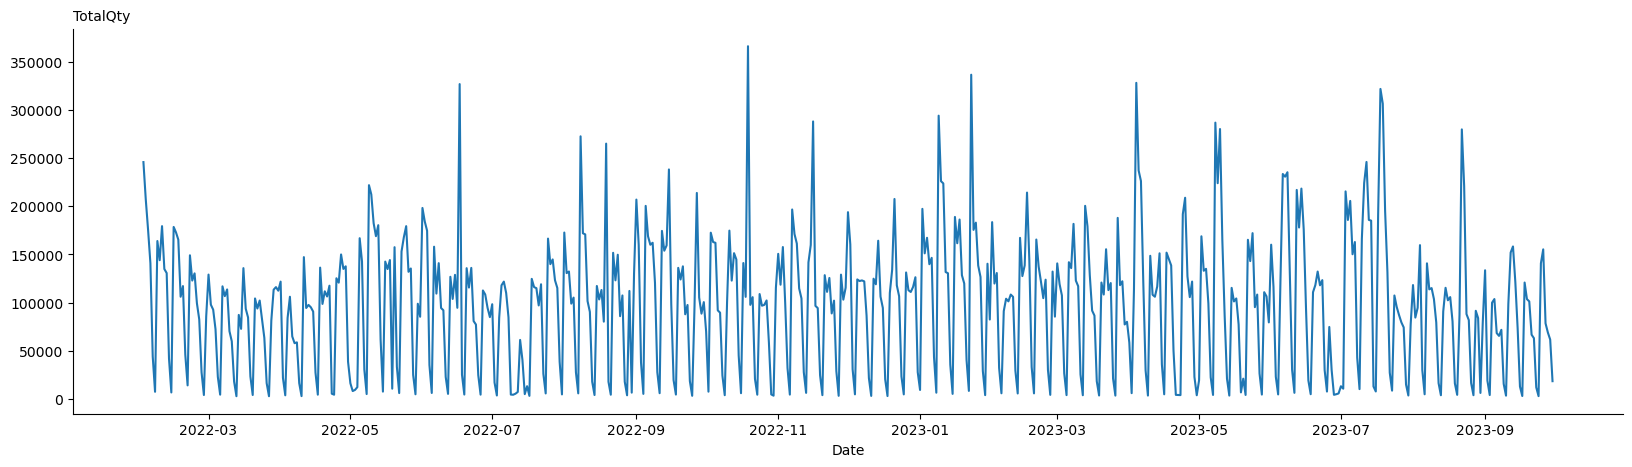

In [56]:
sales = df
sales = sales.groupby([sales['Date'].dt.date])['TotalQty'].sum()
sales.plot(figsize=(20,5), title="TotalQty")
plt.show()

In [57]:
df2 = df[["Date", "TotalQty", "PaidQty", "FreeQty", "isPromoted", "Discount", "DStep"]].set_index("Date")
# Discount: Kullanılan oran, DStep: Geçerli olan teklifin oranı

In [58]:
df2.head()

,TotalQty,PaidQty,FreeQty,isPromoted,Discount,DStep
Date,,,,,,
2023-01-02,10,10,0,0,0.0,0.0
2022-06-29,15,15,0,0,0.0,0.0
2023-01-04,3,3,0,0,0.0,0.0
2022-06-29,15,15,0,0,0.0,0.0
2023-01-04,20,20,0,0,0.0,0.0


In [59]:
fit = smf.ols('TotalQty ~ FreeQty', df2).fit()

In [60]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                 1.158e+07
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:33:53   Log-Likelihood:            -3.2987e+07
No. Observations:             8931111   AIC:                         6.597e+07
Df Residuals:                 8931109   BIC:                         6.597e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1531      0.003   1570.571      0.000       5.147       5.160
FreeQty        2.6839      0.001   3402.640      0.000       2.682       2.685
==============================================================================
Omnibus:                 25864001.967   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   18404874264009.602
Skew:                          38.759   Prob(JB):                         0.00
Kurtosis:                    7035.228   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

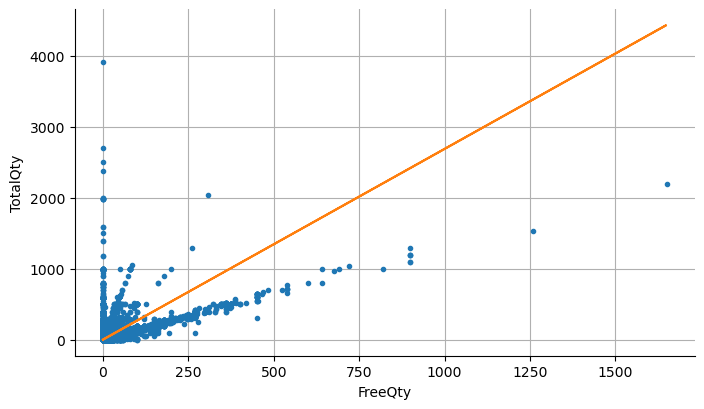

In [63]:
fig, ax = plt.subplots()
ax.plot(df2.FreeQty, df2.PaidQty, '.')
ax.plot(df2.FreeQty, fit.predict())
ax.set(ylabel="TotalQty", xlabel="FreeQty")
ax.grid()

In [ ]:
sns.pairplot(df2, plot_kws=dict(linewidth=0, s=4), corner=True, height=1.55);

In [67]:
fit = smf.ols('TotalQty ~ FreeQty + isPromoted + Discount', df2).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                 4.783e+06
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:37:41   Log-Likelihood:            -3.2421e+07
No. Observations:             8931111   AIC:                         6.484e+07
Df Residuals:                 8931107   BIC:                         6.484e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3427      0.003   1300.469      0.000       4.336       4.349
FreeQty        2.7883      0.001   3395.149      0.000       2.787       2.790
isPromoted    16.4981      0.015   1098.697      0.000      16.469      16.528
Discount     -69.7688      0.077   -901.883      0.000     -69.920     -69.617
==============================================================================
Omnibus:                 27281386.926   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   30288662149571.605
Skew:                          44.974   Prob(JB):                         0.00
Kurtosis:                    9024.346   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Single Product & Daily Aggregation

In [70]:
prod_29 = df
prod_29 = prod_29.groupby([prod_29['Date'].dt.date])[["TotalQty", "FreeQty"]].sum()
prod_29

,TotalQty,FreeQty
Date,,
2022-02-01,245864,22070
2022-02-02,207367,22039
2022-02-03,175478,18156
2022-02-04,140891,13635
2022-02-05,44064,3045
...,...,...
2023-09-26,155265,18971
2023-09-27,78473,6245
2023-09-28,68954,4579


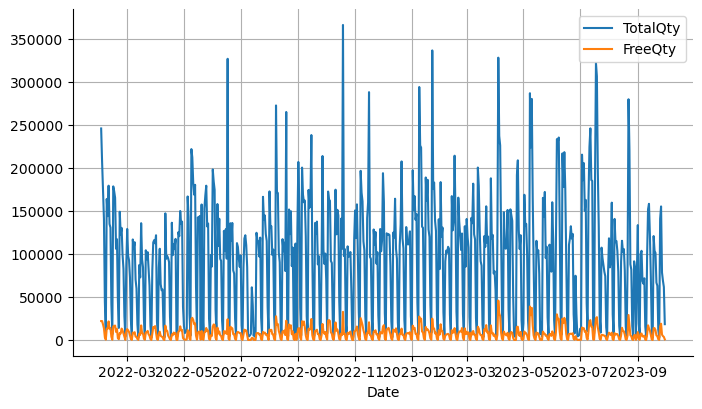

In [71]:
fig, ax = plt.subplots()
prod_29.plot(ax=ax)
ax.grid()

In [72]:
fit = smf.ols('TotalQty ~ FreeQty', prod_29).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     3461.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          1.84e-252
Time:                        13:40:02   Log-Likelihood:                -7049.1
No. Observations:                 607   AIC:                         1.410e+04
Df Residuals:                     605   BIC:                         1.411e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.542e+04   1631.058     15.583      0.000    2.22e+04    2.86e+04
FreeQty        9.0900      0.155     58.828      0.000       8.787       9.393
==============================================================================
Omnibus:                       11.546   Durbin-Watson:                   1.135
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               16.270
Skew:                           0.170   Prob(JB):                     0.000293
Kurtosis:                       3.726   Cond. No.                     1.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

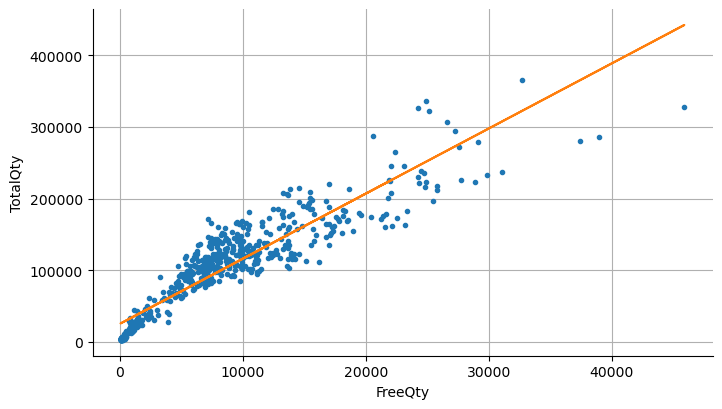

In [74]:
fig, ax = plt.subplots()
ax.plot(prod_29.FreeQty, prod_29.TotalQty, '.')
ax.plot(prod_29.FreeQty, fit.predict())
ax.set(ylabel="TotalQty", xlabel="FreeQty")
ax.grid()

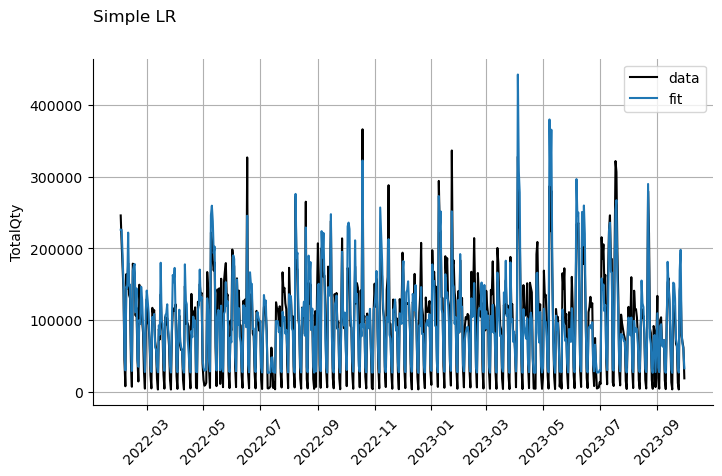

In [75]:
fig, ax = plt.subplots()
ax.plot(prod_29.TotalQty, label='data', color='k')
ax.plot(prod_29.index, fit.predict(), label='fit')
ax.set(ylabel='TotalQty')
suptitle('Simple LR')
plt.xticks(rotation=45)
ax.legend()
ax.grid()

/Users/baris/Desktop/PharmaProject-main/utils.py:124: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dy, bins=np.linspace(lim[0], lim[1], 22),


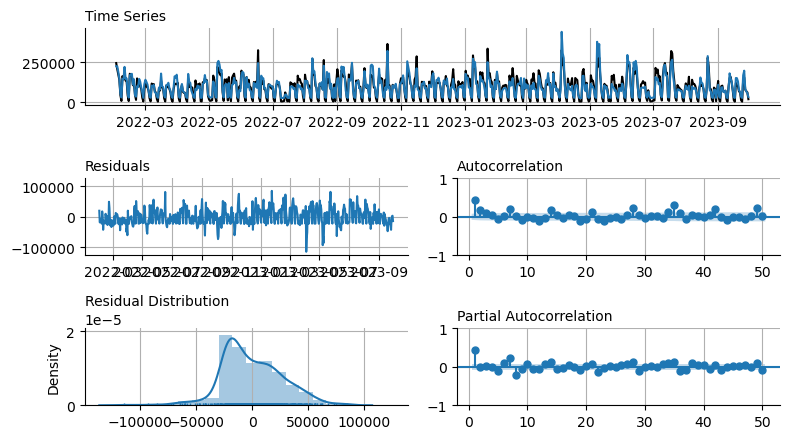

In [76]:
ypred = pd.Series(fit.predict(), index=prod_29.index)
plot_tsresiduals(prod_29.TotalQty, ypred, acf_lags=np.r_[1:51]);

In [96]:
# Model: Weekly plus linear trend.

d = prod_29.assign(
    weekday = prod_29.index.to_series().apply(lambda x: x.weekday()),
    index = np.arange(len(prod_29)))
d.head(7)

,TotalQty,FreeQty,weekday,index
Date,,,,
2022-02-01,NaN,22070,1,0
2022-02-02,NaN,22039,2,1
2022-02-03,NaN,18156,3,2
2022-02-04,NaN,13635,4,3
2022-02-05,NaN,3045,5,4
2022-02-06,NaN,465,6,5
2022-02-07,NaN,13294,0,6


In [80]:
fit = smf.ols('TotalQty ~ index + weekday + FreeQty', d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1427.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          2.21e-273
Time:                        13:44:38   Log-Likelihood:                -6992.4
No. Observations:                 607   AIC:                         1.399e+04
Df Residuals:                     603   BIC:                         1.401e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.905e+04   3560.353     13.775      0.000    4.21e+04     5.6e+04
index         16.8365      5.664      2.973      0.003       5.714      27.960
weekday    -6638.6748    621.624    -10.680      0.000   -7859.486   -5417.864
FreeQty        7.9699      0.176     45.190      0.000       7.624       8.316
==============================================================================
Omnibus:                       35.104   Durbin-Watson:                   1.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.972
Skew:                           0.382   Prob(JB):                     7.79e-15
Kurtosis:                       4.409   Cond. No.                     3.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

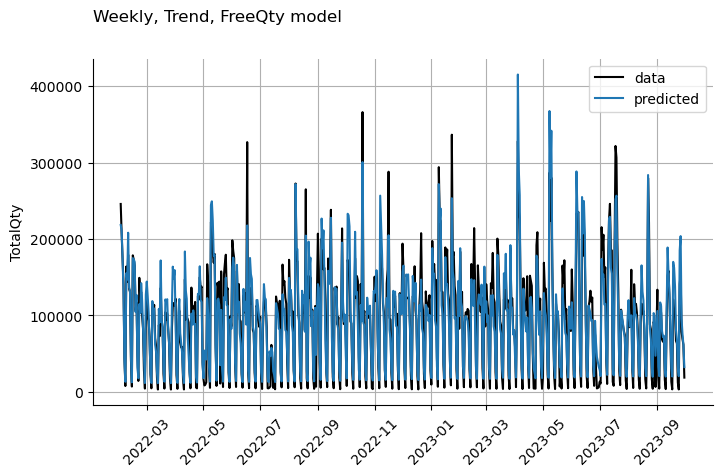

In [82]:
ypred = pd.Series(fit.predict(), index=d.index)
fig, ax = plt.subplots()
ax.plot(d.TotalQty, color='k', label='data')
ax.plot(ypred, label='predicted')
ax.legend()
ax.set(ylabel='TotalQty')
suptitle('Weekly, Trend, FreeQty model')
plt.xticks(rotation=45)
ax.grid()

/Users/baris/Desktop/PharmaProject-main/utils.py:124: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dy, bins=np.linspace(lim[0], lim[1], 22),


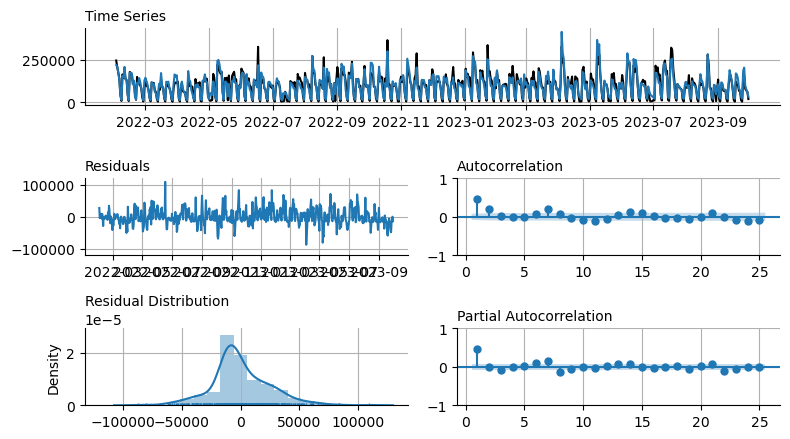

In [83]:
plot_tsresiduals(d.TotalQty, ypred);

In [84]:
dict(rsquared = fit.rsquared,
     rsquared_adj = fit.rsquared_adj,
     aic = fit.aic,
     bic = fit.bic)

{'rsquared': 0.8765544675959823,
 'rsquared_adj': 0.8759403107183503,
 'aic': 13992.819954315684,
 'bic': 14010.454069479922}

# ARIMA Models

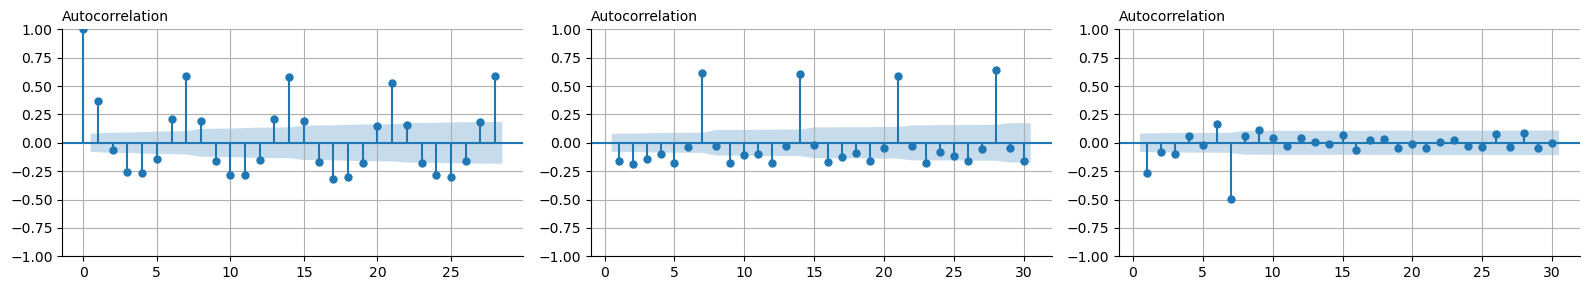

In [85]:
# ACF vs Differenced Series ACF vs Two Times Differenced log Series

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(16,3))
d = prod_29
sm.graphics.tsa.plot_acf(d.TotalQty, ax=a1)
sm.graphics.tsa.plot_acf(d.TotalQty.diff().dropna(), lags=np.r_[1:31], ax=a2)
sm.graphics.tsa.plot_acf(np.log(d.TotalQty).diff().diff(7).dropna(), lags=np.r_[1:31], ax=a3)
[ax.grid() for ax in (a1,a2,a3)]
plt.tight_layout()

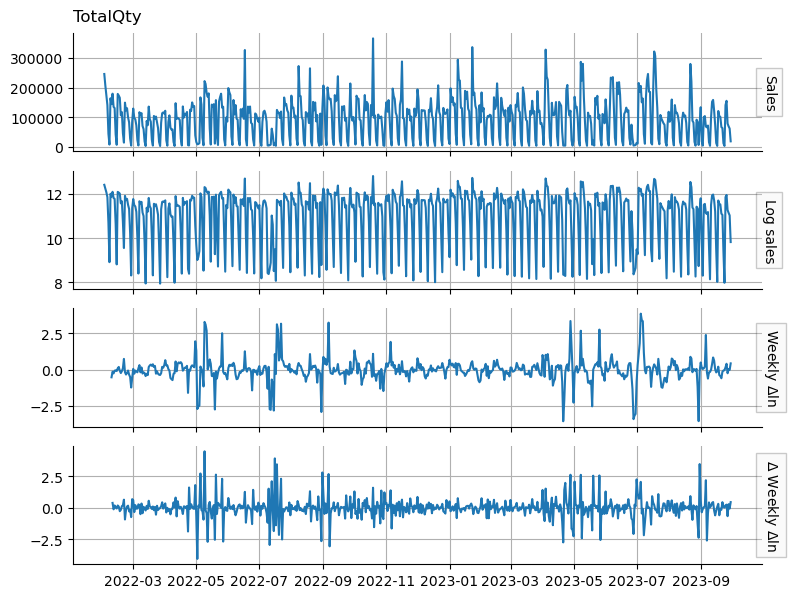

In [88]:
fig, axs = plt.subplots(4, 1, figsize=(8,6), sharex=True)
axs[0].plot(d.TotalQty)
axs[1].plot(np.log(d.TotalQty))
axs[2].plot(np.log(d.TotalQty).diff(7))
axs[3].plot(np.log(d.TotalQty).diff().diff(7))
titles = 'Sales', 'Log sales',  'Weekly $\Delta\ln$', '$\Delta$ Weekly $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('TotalQty')
fig.subplots_adjust(top=.95)

## Unit Root Test

In [89]:
# Unit Root Test

sm.tsa.stattools.kpss(d.TotalQty, nlags='auto')

/var/folders/11/n43tq6bj255drztgc6ydfmdc0000gn/T/ipykernel_3621/617129642.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  sm.tsa.stattools.kpss(d.TotalQty, nlags='auto')


(0.1610592635618093,
 0.1,
 30,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [90]:
sm.tsa.stattools.kpss(np.log(d.TotalQty).diff(7).dropna(), nlags='auto')

/var/folders/11/n43tq6bj255drztgc6ydfmdc0000gn/T/ipykernel_3621/1081958709.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  sm.tsa.stattools.kpss(np.log(d.TotalQty).diff(7).dropna(), nlags='auto')


(0.01354376941296997,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [91]:
sm.tsa.stattools.kpss(np.log(d.TotalQty).dropna(), nlags='auto')

(0.4791463325146719,
 0.04636343862282164,
 550,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## Forecasting for Each Product

In [176]:
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]
df_prod = df
df_prod = df_prod.groupby([df_prod['Date'].dt.date, df_prod["ProductId"]])[["TotalQty", "FreeQty"]].sum()

df_prod = df_prod.reset_index()

df_prod = df_prod.assign(
    weekday = df_prod.Date.apply(lambda x: x.weekday()),
    index = np.arange(len(df_prod)))

for p in products:
    d = df_prod[df_prod.ProductId == p]
    fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
    print("Product ",p," - (R-Squared, Adj R-Squared, AIC = ", [fit.rsquared, fit.rsquared_adj, fit.aic])

Product  14  - (R-Squared, Adj R-Squared, AIC =  [0.9679907392339634, 0.9678847483042745, 8139.4510605872365]
Product  16  - (R-Squared, Adj R-Squared, AIC =  [0.9559131975073507, 0.9557672147176399, 8728.409881220483]
Product  20  - (R-Squared, Adj R-Squared, AIC =  [0.8729305374759889, 0.8725097776663068, 10960.866663829212]
Product  21  - (R-Squared, Adj R-Squared, AIC =  [0.8710963342075444, 0.8706695008771058, 10734.029472568758]
Product  29  - (R-Squared, Adj R-Squared, AIC =  [0.6401474982550972, 0.638955933679783, 11755.985867589694]
Product  30  - (R-Squared, Adj R-Squared, AIC =  [0.9903793628812768, 0.9903475064669764, 9455.255799417888]
Product  32  - (R-Squared, Adj R-Squared, AIC =  [0.9848259731557069, 0.9847757280337059, 8266.303962024158]
Product  38  - (R-Squared, Adj R-Squared, AIC =  [0.9834271726459497, 0.9833722957341813, 9520.980226623242]
Product  39  - (R-Squared, Adj R-Squared, AIC =  [0.9984118513914905, 0.9984065926212636, 10005.507616348703]
Product  41  - 

In [177]:
d = df_prod[df_prod.ProductId == 39]
fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.899e+05
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:55:46   Log-Likelihood:                -4999.8
No. Observations:                 607   AIC:                         1.001e+04
Df Residuals:                     604   BIC:                         1.002e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2031.4547     72.774     27.915      0.000    1888.535    2174.375
FreeQty       13.4477      0.022    598.953      0.000      13.404      13.492
weekday     -275.1967     19.069    -14.432      0.000    -312.646    -237.748
==============================================================================
Omnibus:                      334.936   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4692.368
Skew:                           2.126   Prob(JB):                         0.00
Kurtosis:                      15.940   Cond. No.                     3.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""